In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from glob import glob
import re
from scipy.stats import wilcoxon, mannwhitneyu

# Set default configuration for all plots
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7, 'font.family': 'sans-serif'})
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['axes.labelsize'] = 7
plt.rcParams['axes.titlesize'] = 7
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.25
plt.figsize = (2,2)    

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
# open the file 
files= glob('data/GO_term_analysis/model_compare/sim_rank_*.tsv')


In [5]:
files

['data/GO_term_analysis/model_compare/sim_rank_LLM_processed_model_compare_100set_gpt_4.tsv',
 'data/GO_term_analysis/model_compare/sim_rank_LLM_processed_model_compare_100set_mixtral_instruct.tsv',
 'data/GO_term_analysis/model_compare/sim_rank_LLM_processed_model_compare_100set_llama2_70b.tsv',
 'data/GO_term_analysis/model_compare/sim_rank_LLM_processed_model_compare_100set_gemini_pro.tsv',
 'data/GO_term_analysis/model_compare/sim_rank_LLM_processed_model_compare_100set_gpt_35.tsv']

In [13]:
## combine files and sort by semantic similarity score
all_names_df = pd.DataFrame()
for file in files:
    df = pd.read_csv(file, sep='\t')
    model_name = '_'.join(file.split('/')[-1].split('.')[0].split('_')[-2:])
    # print(model_name)
    if model_name == 'gpt_35':
        prefix = 'gpt_3.5'
    else:
        prefix = model_name
        
    #rename the column
    df.rename(columns={f'{prefix}_default Name': 'LLM name', f'{prefix}_default Score': 'LLM Score'}, inplace=True)
    df = df.loc[:,['GO', 'Term_Description','LLM name', 'LLM Score','LLM_name_GO_term_sim']]
    df.loc[:,'Model'] = prefix
    all_names_df = pd.concat([all_names_df, df])
    print(all_names_df.shape)
all_names_df.sort_values(by='LLM_name_GO_term_sim', ascending=False, inplace=True)

output_df = pd.concat([all_names_df.head(5), all_names_df.tail(5)])
output_df.to_csv('data/GO_term_analysis/model_compare/all_model_top_bottom_5_GO_terms.tsv', sep='\t', index=False) # Table 1 in the manuscript

(100, 6)
(200, 6)
(300, 6)
(400, 6)
(500, 6)


In [3]:
combined_df = pd.DataFrame()
for file in files:
    df = pd.read_csv(file, sep='\t')
    #if the default Name is 'system of unrelated proteins' remove it from the dataframe

    model_name = '_'.join(file.split('/')[-1].split('.')[0].split('_')[-2:])
    # print(model_name)
    if model_name == 'gpt_35':
        prefix = 'gpt_3.5'
    else:
        prefix = model_name
    df = df[df[f'{prefix}_default Name'] != 'System of unrelated proteins']
    # print(df.shape)
    sem_sim = df.loc[:, ['GO', 'LLM_name_GO_term_sim']]
    # sem_sim = df.loc[:, ['GO', 'true_GO_term_sim_percentile']]
    sem_sim['model'] = model_name
    combined_df = pd.concat([combined_df, sem_sim])
combined_df['model'] = combined_df['model'].map({'gpt_4': 'GPT-4', 'gemini_pro': 'Gemini Pro','gpt_35':'GPT-3.5', 'mixtral_instruct': 'Mixtral Instruct', 'llama2_70b': 'Llama2 70b'})
combined_df.head()

,GO,LLM_name_GO_term_sim,model
0,GO:0014744,0.553494,Gemini Pro
1,GO:0000338,0.364746,Gemini Pro
2,GO:0060696,0.455148,Gemini Pro
3,GO:0019885,0.752696,Gemini Pro
4,GO:0003166,0.618279,Gemini Pro


/tmp/ipykernel_2607622/356034981.py:18: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(x='model', y='LLM_name_GO_term_sim', data=combined_df, ax=ax, order=order, palette=['#6CBE4C', '#9C80BB', '#65AFAF', '#E07A5F', '#4579BD'], size=1.75, alpha=1)


model:  GPT-4 median:  0.49406657499999995
model:  Gemini Pro median:  0.45542836
model:  GPT-3.5 median:  0.502566115
model:  Mixtral Instruct median:  0.45095879
model:  Llama2 70b median:  0.4035816


/tmp/ipykernel_2607622/356034981.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['GPT-4', 'Gemini\nPro', 'GPT-3.5','Mixtral\nInstruct', 'Llama2\n70b'],rotation=0, ha='center')


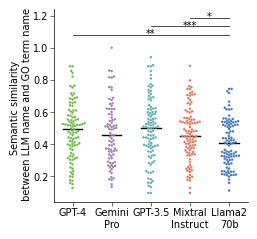

In [5]:
fig, ax = plt.subplots(figsize=(2.5,2.5))
order = ['GPT-4', 'Gemini Pro', 'GPT-3.5','Mixtral Instruct', 'Llama2 70b']
# Perform Mann-Whitney U tests
p_values = {}
for i in range(len(order)):
    for j in range(i+1, len(order)):
        model1 = order[i]
        model2 = order[j]
        data1 = combined_df[combined_df['model'] == model1]['LLM_name_GO_term_sim']
        data2 = combined_df[combined_df['model'] == model2]['LLM_name_GO_term_sim']
        stat, p = mannwhitneyu(data1, data2)
        p_values[(model1, model2)] = p
        
#855C75,#D9AF6B,#AF6458,#736F4C,#526A83,#625377,#68855C,#9C9C5E,#A06177,#8C785D,#467378,#7C7C7C
# sns.violinplot(x='model', y='LLM_name_GO_term_sim', data=combined_df, ax=ax, order=order, inner='quartiles', linewidth=0.5, width=0.8,cut=0, palette=['#d88c9a','#f2d0a9','#f1e3d3','#99c1b9','#d2b7e5'], edgecolor='black')

# Add swarm plot
sns.swarmplot(x='model', y='LLM_name_GO_term_sim', data=combined_df, ax=ax, order=order, palette=['#6CBE4C', '#9C80BB', '#65AFAF', '#E07A5F', '#4579BD'], size=1.75, alpha=1)
# add median line 
medians = combined_df.groupby(['model'])['LLM_name_GO_term_sim'].median()
for i in range(len(order)):
    print('model: ', order[i], 'median: ', medians[order[i]])
    ax.plot([i-0.25, i+0.25], [medians[order[i]], medians[order[i]]], lw=1, color='black')


# Determine the maximum y-value
max_y = max(combined_df['LLM_name_GO_term_sim']) + 0.03  # Adjust the 0.03 if needed

# Offset for each bar to prevent overlap
bar_offset = max_y * 0.05  
i = 0
# Loop through your p-values and add bars for each significant pair
for index, ((model1, model2), p_value) in enumerate(p_values.items()):
    if p_value < 0.05:  # Only plot bars for significant differences
        bar_start = order.index(model1)  # x-coordinate for model1
        bar_end = order.index(model2)    # x-coordinate for model2

        # Adjust y-coordinate for the bar to avoid overlap
        y_coord = max_y + bar_offset + (i * bar_offset)

        # Plot the horizontal line for the significance bar
        ax.plot([bar_start, bar_end], [y_coord, y_coord], color='black', lw=0.5)

        # Add text for significance level
        significance_text = "****" if p_value < 0.0001 else "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*"
        ax.text((bar_start + bar_end) / 2, y_coord - 0.01, significance_text, ha='center')
        i += 1


ax.set_ylabel('Semantic similarity \n between LLM name and GO term name')
ax.set_xlabel('')
ax.set_xticklabels(['GPT-4', 'Gemini\nPro', 'GPT-3.5','Mixtral\nInstruct', 'Llama2\n70b'],rotation=0, ha='center')
sns.despine()
plt.savefig('figures/model_compare/compare_raw_semantic_similarity_swamp_only.svg', bbox_inches='tight')
plt.show()


# Compare the semantic similarity vs confidence score

GPT-4 correlation:  0.5534823743144983
Gemini Pro correlation:  0.761474637375298
GPT-3.5 correlation:  0.37603379465572917
Mixtral Instruct correlation:  0.27831611044173465
Llama2 70b correlation:  0.14668758679415983


/tmp/ipykernel_1631187/1479142643.py:80: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(x=f'{prefix}_default Score Bin', y='LLM_name_GO_term_sim', data=model_data, ax=ax, order=labels, size=1.5, alpha=1, palette=label_colors)
/cellar/users/mhu/miniconda3/envs/llm_eval/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/cellar/users/mhu/miniconda3/envs/llm_eval/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/cellar/users/mhu/miniconda3/envs/llm_eval/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/tmp/ipykernel_1631187/1479142643.py:80: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(x=f'{prefix}_default Sco

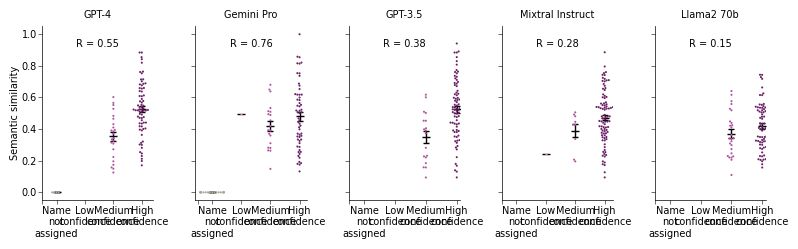

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, sem, pearsonr
from glob import glob

# Define the desired order of the models
model_order = ['GPT-4', 'Gemini Pro', 'GPT-3.5', 'Mixtral Instruct', 'Llama2 70b']

# Adjust the file paths and models accordingly
files = glob('data/GO_term_analysis/model_compare/sim_rank_*.tsv')
combined_df = pd.DataFrame()
models = []

# Define model name mappings for consistent naming
model_name_map = {
    'gpt_4': 'GPT-4',
    'gemini_pro': 'Gemini Pro',
    'gpt_3.5': 'GPT-3.5',
    'mixtral_instruct': 'Mixtral Instruct',
    'llama2_70b': 'Llama2 70b'
}

# Read and preprocess the data
for file in files:
    df = pd.read_csv(file, sep='\t')
    model_name = '_'.join(file.split('/')[-1].split('.')[0].split('_')[-2:])
    if model_name == 'gpt_35':
        prefix = 'gpt_3.5'
    else:
        prefix = model_name
    
    # df = df[df[f'{prefix}_default Name'] != 'System of unrelated proteins']

    df['model'] = model_name_map[prefix]  # Add a column to identify the model
    combined_df = pd.concat([combined_df, df])
    models.append(prefix)

labels = ['Name not assigned', 'Low Confidence', 'Medium Confidence', 'High Confidence']
label_colors = {'Name not assigned': '#A5AA99', 'Low Confidence': '#e39cc5', 'Medium Confidence': '#af549e', 'High Confidence': '#6c2167'}

# Calculate correlation coefficient
correlation_coeffs = {}
for model_name in model_order:
    model_data = combined_df[combined_df['model'] == model_name]
    if not model_data.empty:
        prefix = model_name.replace(" ", "_").replace("-", "_").lower()
        correlation_coeffs[model_name] = model_data[f'{prefix}_default Score'].corr(model_data['LLM_name_GO_term_sim']) #pairwise correlation using pearson correlation
        print(f'{model_name} correlation: ', correlation_coeffs[model_name])

# Perform Mann-Whitney U tests
p_values = {}
for model_name in model_order:
    df_bins = labels 
    for i in range(len(df_bins)):
        for j in range(i+1, len(df_bins)):
            scorebin1 = df_bins[i]
            scorebin2 = df_bins[j]
            prefix = model_name.replace(" ", "_").replace("-", "_").lower()
            data1 = combined_df[(combined_df[f'{prefix}_default Score Bin'] == scorebin1) & (combined_df['model'] == model_name)]['LLM_name_GO_term_sim']
            data2 = combined_df[(combined_df[f'{prefix}_default Score Bin'] == scorebin2) & (combined_df['model'] == model_name)]['LLM_name_GO_term_sim']
            if len(data1) == 0 or len(data2) == 0:
                continue
                
            stat, p = mannwhitneyu(data1, data2)
            p_values[(model_name, scorebin1, scorebin2)] = p

fig, axs = plt.subplots(1, len(model_order), figsize=(8,2.5), sharey=True)

for ax, model_name in zip(axs, model_order):
    model_data = combined_df[combined_df['model'] == model_name]
    
    # Ensure all categories are listed, add missing categories with NaNs
    prefix = model_name.replace(" ", "_").replace("-", "_").lower()
    for label in labels:
        if label not in model_data[f'{prefix}_default Score Bin'].unique():
            blank_data = pd.DataFrame({f'{prefix}_default Score Bin': [label], 'LLM_name_GO_term_sim': [float('nan')]})
            model_data = pd.concat([model_data, blank_data], ignore_index=True)
    
    sns.swarmplot(x=f'{prefix}_default Score Bin', y='LLM_name_GO_term_sim', data=model_data, ax=ax, order=labels, size=1.5, alpha=1, palette=label_colors)
    
    # Add mean and SE
    means = model_data.groupby(f'{prefix}_default Score Bin')['LLM_name_GO_term_sim'].mean()
    ses = model_data.groupby(f'{prefix}_default Score Bin')['LLM_name_GO_term_sim'].apply(sem)
    for idx, label in enumerate(labels):
        if label in means.index:
            mean = means[label]
            se = ses[label]
            ax.errorbar(idx, mean, yerr=se, fmt='_', color='black', ecolor='black', elinewidth=1, capsize=2)
    
    # Display correlation coefficient
    if model_name in correlation_coeffs:
        ax.text(0.5, 0.9, f'R = {correlation_coeffs[model_name]:.2f}', ha='center', va='center', transform=ax.transAxes, fontsize=7)
    
    ax.set_xlabel('')
    ax.set_xticks([-0.5] + list(range(len(labels)))) # Ensure all categories are listed
    ax.set_xticklabels(['', 'Name\nnot\nassigned','Low\nconfidence', 'Medium\nconfidence', 'High\nconfidence'])
    ax.set_title(model_name)

axs[0].set_ylabel('Semantic similarity')

sns.despine()
plt.tight_layout()
plt.savefig('figures/model_compare/compare_semantic_similarity_by_confidence_bins.svg', bbox_inches='tight')
plt.show()